
# CP322 — Assignment 2: Fake vs Real News Classification

**Dataset:** Fake and Real News — Kaggle  
**Goal:** Build classifiers (Naive Bayes, Logistic Regression, MLP) to detect fake news from text.  
**Student:** Jay Patel


In [1]:
import sys
print(sys.executable)

/usr/local/bin/python3.11


In [2]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [3]:
import nltk
print(nltk.__version__)

3.9.2


In [4]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
print(torch.__version__)

2.9.0


In [6]:
pip install numpy pandas matplotlib scikit-learn nltk torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


## 0) Setup & Imports

In [ ]:
import os, random, re, string, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split  
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

plt.rcParams.update({"figure.figsize": (8, 5), "axes.grid": True})

RANDOM_SEED = 19
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


## 1) Data Exploration & Preprocessing (5 pts)


### 1.1 Load & Merge
Load `True.csv` (label=0) and `Fake.csv` (label=1). Keep `title` and `text` only.

#### 1. Download the Fake/Real News dataset from Kaggle.
#### 2. Load both files and focus on the title and text columns, ignoring subject and date. Assign label=1 for fake news and label=0 for real news. Merge these into a single dataset.
#### 3. To demonstrate class imbalance, randomly undersample 20,000 real news and 1,000 fake news, and combine them into a new DataFrame. Use bar plot to show the distribution of labels after downsampling


In [12]:

FAKE_PATH = "Fake.csv"
REAL_PATH = "True.csv"

df_fake = pd.read_csv(FAKE_PATH, usecols=["title", "text"])
df_real = pd.read_csv(REAL_PATH, usecols=["title", "text"])
df_fake["label"] = 1  # fake -> 1
df_real["label"] = 0  # real -> 0

df_all = pd.concat([df_fake, df_real], ignore_index=True)
print("Full dataset shape:", df_all.shape)
df_all.head()


Full dataset shape: (44898, 3)


,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Mess...,Donald Trump just couldn t wish all Americans a Happy Ne...,1
1,Drunk Bragging Trump Staffer Started Russian Collusion ...,House Intelligence Committee Chairman Devin Nunes is goi...,1
2,Sheriff David Clarke Becomes An Internet Joke For Threa...,"On Friday, it was revealed that former Milwaukee Sheriff...",1
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Int...,"On Christmas day, Donald Trump announced that he would ...",1
4,Pope Francis Just Called Out Donald Trump During His Ch...,Pope Francis used his annual Christmas Day message to re...,1


### 1.2 Class Distribution & Missing Values

#### 1. Check for missing values (e.g., empty titles or text).
#### 2. Decide whether to drop or impute missing data based on the observation and give an explanation

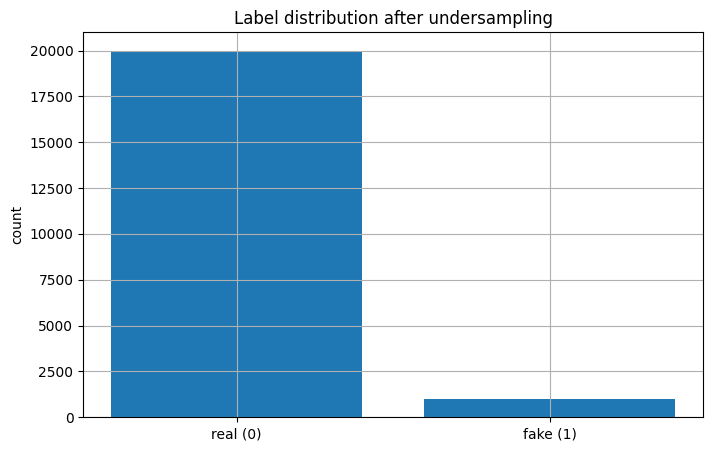

In [13]:

real_sample_n = min(20000, (df_all["label"]==0).sum())
fake_sample_n = min(1000,  (df_all["label"]==1).sum())

df_real_ds = df_all[df_all["label"]==0].sample(real_sample_n, random_state=RANDOM_SEED)
df_fake_ds = df_all[df_all["label"]==1].sample(fake_sample_n, random_state=RANDOM_SEED)
df_ds = shuffle(pd.concat([df_real_ds, df_fake_ds], ignore_index=True), random_state=RANDOM_SEED)


vc = df_ds["label"].value_counts().sort_index()
plt.bar(["real (0)", "fake (1)"], vc.values)
plt.title("Label distribution after undersampling")
plt.ylabel("count")
plt.show()


### 1.3 Text Preprocessing (tokenize, lowercase, stopwords, lemmatize)

#### 1. Tokenize the text.

#### 2. Remove stopwords (English).
#### 3. Lemmatize with WordNetLemmatizer()
#### 4. Convert text to lowercase.
#### 5. Show the top-5 rows of the DataFrame

In [ ]:
# --- 1.3 Text Preprocessing (no NLTK; regex tokenizer, concise preview) ---

# 1) Pick the working dataframe (expects columns: title, text, label)
if 'df' in locals():
    _base = df
elif 'df_ds' in locals():
    _base = df_ds
else:
    raise NameError("No dataframe named 'df' or 'df_ds' found. Run 1.1/1.2 first.")

req = {"title", "text", "label"}
missing = req - set(_base.columns)
if missing:
    raise KeyError(f"Missing columns: {missing}. Ensure your data has title, text, label.")

# 2) Lightweight stopword set (good enough for TF-IDF baseline)
_stop = {
    "the","a","an","and","or","but","if","while","is","are","was","were","be","been",
    "to","of","in","on","for","with","as","by","at","from","that","this","it","its",
    "i","you","he","she","they","we","his","her","their","our","your","not"
}

def normalize_text(s: str) -> str:
    # lowercase, remove punctuation, regex-tokenize alpha tokens, drop stopwords
    s = s.lower()
    s = s.translate(str.maketrans("", "", string.punctuation))
    tokens = re.findall(r"[a-z]+", s)
    tokens = [t for t in tokens if t not in _stop]
    return " ".join(tokens)

# 3) Combine title + text, then preprocess to text_clean
_base["text_raw"] = (_base["title"].fillna("") + " " + _base["text"].fillna("")).astype(str)
_base["text_clean"] = _base["text_raw"].apply(normalize_text)

# 4) Concise preview of the first 5 rows
pd.set_option("display.max_colwidth", 60)

def first_words(s, k=20):
    s = s.fillna('')
    parts = s.str.split()
    return parts.str[:k].str.join(' ') + np.where(parts.str.len() > k, ' …', '')

preview = _base[["label","title","text_clean"]].copy()
preview["title"] = first_words(preview["title"], 12)
preview["text_clean"] = first_words(preview["text_clean"], 20)

try:
    from IPython.display import display
    display(preview.head(5))
except Exception:
    print(preview.head(5).to_string())


NameError: name '_base' is not defined

## 2) Feature Engineering (1 pt)

#### 1. Bag-of-Words / TF-IDF Representation
##### • Convert the processed text into numeric features using scikit-learn’s TfidfVectorizer.
##### • Set parameters, such as ngram range of using unigram and max features=5000, etc.

#### 2. Split into Training and Test Sets
##### • Use an 80/20 split for training and test.
##### • Keep in mind the class imbalance and apply stratified sampling

In [ ]:

_base = df if 'df' in locals() else (df_ds if 'df_ds' in locals() else None)
assert _base is not None and {"text_clean","label"}.issubset(_base.columns)

tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=5000)
X = tfidf.fit_transform(_base["text_clean"])
y = _base["label"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=19
)
print("TF-IDF shape:", X.shape, "| Train/Test:", X_train.shape, X_test.shape)


TF-IDF shape: (44898, 5000) | Train/Test: (35918, 5000) (8980, 5000)


## 3) Naive Bayes & Logistic Regression (2 pts)

#### 1. Naive Bayesian
##### • Train a GaussianNB classifier on the vectorized data.
#### 2. Logistic Regression
##### • Train a logistic regression classifier on the vectorized data. Use max iter=100 to allow the model to converge

In [ ]:

# GaussianNB 
X_train_gnb = X_train.toarray().astype(np.float32)
X_test_gnb  = X_test.toarray().astype(np.float32)

gnb = GaussianNB()
gnb.fit(X_train_gnb, y_train)
y_pred_gnb  = gnb.predict(X_test_gnb)
y_proba_gnb = gnb.predict_proba(X_test_gnb)[:, 1]

# Logistic Regression 
logreg = LogisticRegression(max_iter=100)
logreg.fit(X_train, y_train)
y_pred_lr  = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:, 1]



NameError: name 'X_train' is not defined

## 4) Multilayer Perceptron (PyTorch) (2 pts)


####  1. Neural Network Architecture
##### • The network should have two hidden layers, each with 128 units, using ReLU activations after the linear transfor- mations.
##### • The output layer should have one unit with a sigmoid activation so that the model produces probabilities between 0 and 1.
#### 2. Training and optimization
##### • Use binary cross-entropy loss (nn.BCELoss) and optimize with Adam at a learning rate of 0.001.
##### • Train the model for 20 epochs using the training data, making sure the input dimension matches the number of features in training data

In [ ]:


Xtr_dense = torch.tensor(X_train.toarray(), dtype=torch.float32)
Xte_dense = torch.tensor(X_test.toarray(),  dtype=torch.float32)
ytr_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

input_dim = Xtr_dense.shape[1]

class MLP(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),  
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_ds = TensorDataset(Xtr_dense, ytr_t)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

epochs = 20
model.train()
for ep in range(1, epochs + 1):
    total = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    print(f"Epoch {ep:02d} | loss = {total/len(train_ds):.4f}")

model.eval()
with torch.no_grad():
    proba_mlp = model(Xte_dense.to(device)).squeeze(1).cpu().numpy()
pred_mlp = (proba_mlp >= 0.5).astype(int)



Epoch 01 | loss = 0.2212
Epoch 02 | loss = 0.0275
Epoch 03 | loss = 0.0111
Epoch 04 | loss = 0.0045
Epoch 05 | loss = 0.0021
Epoch 06 | loss = 0.0012
Epoch 07 | loss = 0.0008
Epoch 08 | loss = 0.0005
Epoch 09 | loss = 0.0007
Epoch 10 | loss = 0.0004
Epoch 11 | loss = 0.0005
Epoch 12 | loss = 0.0002
Epoch 13 | loss = 0.0005
Epoch 14 | loss = 0.0002
Epoch 15 | loss = 0.0004
Epoch 16 | loss = 0.0006
Epoch 17 | loss = 0.0002
Epoch 18 | loss = 0.0006
Epoch 19 | loss = 0.0003
Epoch 20 | loss = 0.0002


## 5) Evaluation (5 pts)

### 5.1 Metrics

##### • Report above three models’ evaluation metrics including accuracy, precision, recall, F1-score, and AUC-ROC

In [ ]:

def report_metrics(y_true, y_pred, y_proba, name):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    print(f"[{name}]  Acc={acc:.4f}  Prec={pre:.4f}  Rec={rec:.4f}  F1={f1:.4f}  AUC={auc:.4f}")
    return acc, pre, rec, f1, auc

m_gnb = report_metrics(y_test, y_pred_gnb, y_proba_gnb, "GaussianNB")
m_lr  = report_metrics(y_test, y_pred_lr,  y_proba_lr,  "LogisticRegression")


[GaussianNB]  Acc=0.9214  Prec=0.9112  Rec=0.9414  F1=0.9261  AUC=0.9312
[LogisticRegression]  Acc=0.9879  Prec=0.9906  Rec=0.9862  F1=0.9884  AUC=0.9989


### 5.2 Confusion Matricies

##### • Plot the confusion matrix for all three methods.
##### • Interpret false positives and false negatives for this imbalanced dataset.


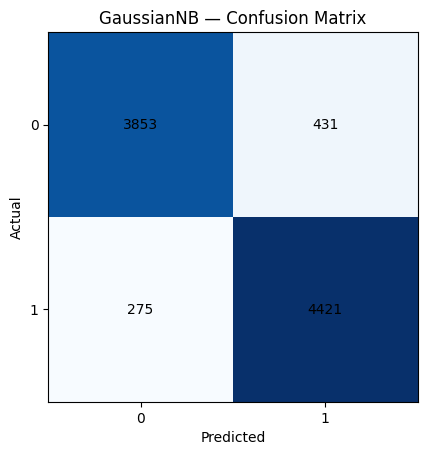

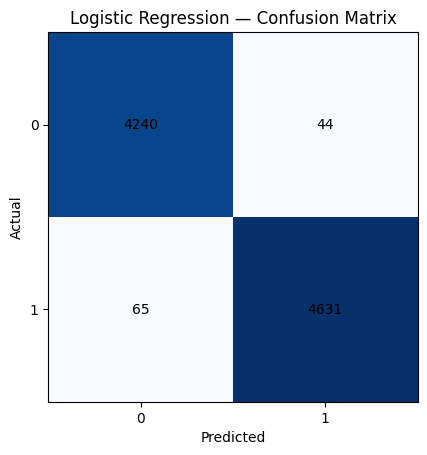

In [ ]:

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, int(v), ha='center', va='center')
    plt.show()

plot_cm(y_test, y_pred_gnb, "GaussianNB — Confusion Matrix")
plot_cm(y_test, y_pred_lr,  "Logistic Regression — Confusion Matrix")


### 5.3 ROC curves

##### • Draw ROC curves of three models in a single plot.

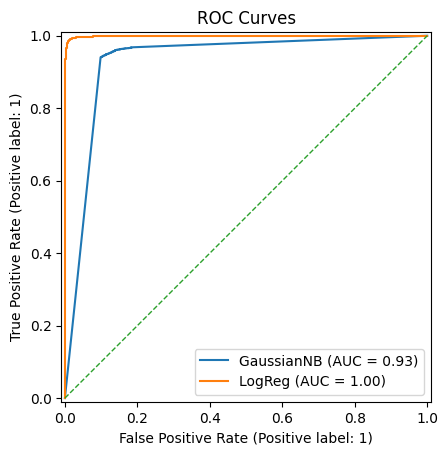

In [ ]:

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_proba_gnb, name="GaussianNB", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_lr,  name="LogReg",     ax=ax)
ax.plot([0,1],[0,1],'--', linewidth=1)
ax.set_title("ROC Curves")
plt.show()
